In [1]:

import warnings
warnings.filterwarnings('ignore')

import json
import glob
import itertools

import numpy as np
import pandas as pd

from qiskit import transpile, QuantumCircuit
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp


import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import (
    GCNConv, 
    TransformerConv, 
    GATv2Conv, 
    global_mean_pool, 
    Linear, 
    ChebConv, 
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit.quantum_info import random_clifford


from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator

from pprint import pprint

In [2]:
%load_ext snakeviz

In [3]:
import numpy as np

from qiskit.qasm import pi

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Reset
from qiskit.circuit.library.standard_gates import (
    IGate,
    XGate,
    YGate,
    ZGate,
    HGate,
    SGate,
    SdgGate,
    CXGate,
    CYGate,
    CZGate,
    SwapGate,
    U1Gate
)
from qiskit.circuit.exceptions import CircuitError
from qiskit.quantum_info import Clifford


def random_clifford_circuit(
    num_qubits, depth, max_operands=2, reset=False, seed=None
):
    """Generate random circuit of arbitrary size and form.

    This function will generate a random circuit by randomly selecting gates
    from the set of Clifford gates.

    Args:
        num_qubits (int): number of quantum wires
        depth (int): layers of operations (i.e. critical path length)
        max_operands (int): maximum operands of each gate (between 1 and 3)
        reset (bool): if True, insert middle resets
        seed (int): sets random seed (optional)

    Returns:
        QuantumCircuit: constructed circuit

    Raises:
        CircuitError: when invalid options given
    """
    if max_operands < 1 or max_operands > 2:
        raise CircuitError("max_operands must be 1 or 2")

    one_q_ops = [
        IGate,
        XGate,
        YGate,
        ZGate,
        HGate,
        # SGate,
        # SdgGate,
    ]
    one_param = []
    two_param = []
    three_param = []
    two_q_ops = [
        CXGate, 
        # CYGate, 
        # CZGate, 
        # SwapGate
    ]
    three_q_ops = []

    qr = QuantumRegister(num_qubits, "q")
    qc = QuantumCircuit(num_qubits)

    if reset:
        one_q_ops += [Reset]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.default_rng(seed)

    # apply arbitrary random operations at every depth
    for _ in range(depth):
        # choose either 1, 2, or 3 qubits for the operation
        remaining_qubits = list(range(num_qubits))
        rng.shuffle(remaining_qubits)
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), max_operands)
            num_operands = rng.choice(range(max_possible_operands)) + 1
            operands = [remaining_qubits.pop() for _ in range(num_operands)]
            if num_operands == 1:
                operation = rng.choice(one_q_ops)
            elif num_operands == 2:
                operation = rng.choice(two_q_ops)
            register_operands = [qr[i] for i in operands]
            op = operation()

            qc.append(op, register_operands)

    return qc

In [4]:
import copy
import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister
from qiskit.quantum_info import Clifford

def force_nonzero_expectation_from_clifford_circuit(clifford_circuit, print_bool=False):
    """Force the input Clifford `QuantumCircuit` to have a non-zero expectation value when measured in the all-Z basis.

    Args:
        clifford (QuantumCircuit): Clifford as a QuantumCircuit.
        print (bool, optional): Print the chosen random stabilizer.
    """
    # Convert the Clifford circuit into a `Clifford` object
    clifford = Clifford(clifford_circuit)
    # Copy the Clifford circuit into the quantum circuit that will be returned
    qc_forced = copy.deepcopy(clifford_circuit)

    # Get the stabilizers as a list of strings.
    # An example of a stabilizer string is "+XYZ"
    # with sign "+" and "Z" on qubit 1.
    stabilizers = clifford.to_dict()['stabilizer']
    for idx, stab in enumerate(stabilizers):
        stabilizer = stab

        # # This method of forcing the Clifford operator to have
        # # non-zero expectation in the all-Z basis only works
        # # if the chosen stabilizer has no identity matrices.
        # if 'I' not in stab:
        #     stabilizer = stab
        #     break
        # # If we have tried every stabilizer, throw an exception
        # if idx >= len(stabilizers)-1:
        #     raise Exception("All of the stabilizers have the identity matrix I!")
    if print_bool:
        print(f'Stabilizer: {stabilizer}')

    # Since the Clifford circuit has no classical register, add one
    cr = ClassicalRegister(qc_forced.num_qubits)
    qc_forced.add_register(cr)

    # Change the measurement basis of each qubit
    for qubit in range(0, qc_forced.num_qubits):
        op = stabilizer[qc_forced.num_qubits-qubit]
        if op == 'X':
            qc_forced.append(HGate(), [[qubit]]) # Convert to x-basis measurement            
        elif op == 'Y':
            qc_forced.append(SdgGate(), [[qubit]])
            qc_forced.append(HGate(), [[qubit]])   
        # # Measure qubit and store in classical bit
        # if measure and op != 'I':
        #     qc_forced.measure([qubit], [qubit])

    # Compute the expectation value based on the sign of the stabilizer
    if stabilizer[0] == '+':
        expectation = 1
    elif stabilizer[0] == '-':
        expectation = -1

    # Make observable
    mapping = {
        "I": "I",
        "X": "Z",
        "Y": "Z",
        "Z": "Z"
    }
    observable = "".join([
        mapping[stabilizer[i]]
        for i in range(1, qc_forced.num_qubits + 1)
    ])
        
    return qc_forced, expectation, observable
    

def cal_all_z_exp(counts):
    """
    Compute the Z^N expectation value, where N is the number of bits in each bitstring

    Parameters
    ----------
    counts : dict
        Dictionary of state labels (keys, e.g. '000', '001') and
        counts (ints, e.g. 900, 100, 24 that add up to the total shots 1024)

    Returns
    -------
    all_z_exp : float
    """
    shots = sum(list(counts.values()))
    all_z_exp = 0
    for key, value in counts.items():
        num_ones = key.count('1')
        sign = (-1) ** (num_ones) # Sign of the term in 'key' depends on the number of 0's, e.g. '11' is +, '110' is -
        all_z_exp += sign * value
    all_z_exp = all_z_exp / shots
    return all_z_exp


def encode_obs(obs: str) -> list:
    """Encodes obs into feature vector."""
    mapping = {
        "I": 0,
        "Z": 1
    }
    return [mapping[e] for e in obs]

In [5]:
qc = random_clifford_circuit(100, 5)
qc_forced, expectation, observable = force_nonzero_expectation_from_clifford_circuit(qc, print_bool=False)

print(expectation, observable)
print(encode_obs(observable))

1 ZIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
from qiskit.providers.fake_provider import ConfigurableFakeBackend

In [7]:
from qiskit.providers.aer.utils import approximate_noise_model


In [8]:
from qiskit_aer import noise

# Import Aer QuantumError functions that will be used
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import reset_error
from qiskit.providers.aer.noise import pauli_error

In [9]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['id', 'x', 'y', 'z', 'h'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

In [10]:
aer_noisy_sim = AerSimulator(method='stabilizer', noise_model=noise_model)

aer_estimator = AerEstimator()
aer_estimator._backend = aer_noisy_sim

In [11]:
backend = ConfigurableFakeBackend("tash", n_qubits=100, 
                                  basis_gates=['id', 'x', 'y', 'z', 'h', 'cx', 'sdg'],
                                  single_qubit_gates=['id', 'x', 'y', 'z', 'h', 'sdg'])


properties = get_backend_properties_v1(backend)

In [12]:
# approximate_noise_model(washington_noise_model, operator_string="clifford")

In [13]:
def generate_composed_clifford(n_qubits: int, depth: int):
    if n_qubits <= 20:
        return random_clifford_circuit(n_qubits, depth)
        
    ranges = list(
            zip(
                range(0, n_qubits, 20),
                [x + 20 for x in range(0, n_qubits, 20)]
            )
    )[:-1]
    
    qc = QuantumCircuit(n_qubits)

    for r in ranges:
        qc.append(
            random_clifford_circuit(20, depth), 
            qargs=range(r[0], r[1])
        )
        
    return qc.decompose()

In [14]:
## Genrate data

In [15]:
aer_noisy_sim = AerSimulator(method='stabilizer', noise_model=noise_model)
aer_noisy_estimator = AerEstimator()
aer_noisy_estimator._backend = aer_noisy_sim

aer_ideal_sim = AerSimulator(method='stabilizer')
aer_ideal_estimator = AerEstimator()
aer_ideal_estimator._backend = aer_noisy_sim


depths = range(1, 10, 3)
n_qubits_settings = [5, 20, 50, 100, 200, 400]
N_CIRCUITS = 20
N_FILES_PER_ITERATION = 10
SHOTS = 1000

for n_qubits in tqdm_notebook(n_qubits_settings):
    print(f"Number of qubits {n_qubits}...")
    backend = ConfigurableFakeBackend("tash", n_qubits=n_qubits, version=1,
                                  basis_gates=['id', 'x', 'y', 'z', 'h', 'cx'],
                                  single_qubit_gates=['id', 'x', 'y', 'z', 'h'])
    properties = get_backend_properties_v1(backend)
    
    observable = SparsePauliOp(["".join(["Z" for _ in range(n_qubits)])])
    encoded_obs = encode_pauli_sum_op(observable)
    
    for depth in depths:
        print(f"Depth {depth}...")
        
        for i in range(N_FILES_PER_ITERATION):
            print(".", end="")
            
            entries = []
            for _ in range(N_CIRCUITS):
                circuit = generate_composed_clifford(n_qubits, depth)
                
                exp_vals = create_meas_data_from_estimators(
                    circuits=circuit, 
                    observables=observable, 
                    estimators=[
                        aer_ideal_estimator, 
                        aer_noisy_estimator
                    ],
                    shots=SHOTS
                )
                ideal_exp_val, noisy_exp_val = exp_vals
                
                graph_data = circuit_to_graph_data_json(
                    circuit=circuit,
                    properties=properties,
                    use_qubit_features=True,
                    use_gate_features=True,
                )
                
                entry = ExpValueEntry(
                    circuit_graph=graph_data,
                    observable=encoded_obs,
                    ideal_exp_value=expectation,
                    noisy_exp_values=[
                        noisy_exp_val
                    ]
                )
                
                entries.append(
                    entry.to_dict()
                )

            with open(f"./data/scalability_test/pyg_data/{n_qubits}_{depth}_{i}.json", "w") as f:
                json.dump(entries, f)

  0%|          | 0/6 [00:00<?, ?it/s]

Number of qubits 5...
Depth 1...
..........Depth 4...
..........Depth 7...
..........Number of qubits 20...
Depth 1...
..........Depth 4...
..........Depth 7...
..........Number of qubits 50...
Depth 1...
..........Depth 4...
..........Depth 7...
..........Number of qubits 100...
Depth 1...
..........Depth 4...
..........Depth 7...
..........Number of qubits 200...
Depth 1...
..........Depth 4...
..........Depth 7...
..........Number of qubits 400...
Depth 1...
..........Depth 4...
..........Depth 7...
..........

In [112]:
depths = range(1, 101, 20)
N_FILES_PER_DEPTH = 1
N_ENTRIES = 1


for depth in depths:
    for i in tqdm_notebook(range(N_FILES_PER_DEPTH)):
        entries = []

        for _ in range(N_ENTRIES):
            circuit = random_clifford_circuit(100, depth)

            qc_forced, expectation, observable = force_nonzero_expectation_from_clifford_circuit(
                circuit, print_bool=False
            )
            transpiled = transpile(
                qc_forced, 
                aer_noisy_sim, 
                optimization_level=0, 
                seed_transpiler=42
            )

            noisy_exp_val = aer_estimator.run(
                [transpiled], 
                [SparsePauliOp([observable])], 
                shots=1000,
                skip_transpilation=True
            ).result().values[0]

            graph_data = circuit_to_graph_data_json(
                circuit=transpiled,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )
            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=encode_obs(observable),
                ideal_exp_value=expectation,
                noisy_exp_values=[
                    noisy_exp_val
                ],
                circuit_depth=qc_forced.depth()
            )

            entries.append(
                entry.to_dict()
            )

        with open(f"./data/scalability_test/pyg_data/{depth}_{i}.json", "w") as f:
            json.dump(entries, f)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
## Load data and train

In [ ]:
train_size = 3

all_paths = {}
for depth in depths:
    all_paths[depth] = glob.glob(f"./data/scalability_test/pyg_data/{depth}_**.json")

train_paths = []
val_paths = []
test_paths = []

for i, (depth, paths) in enumerate(all_paths.items()):
    train_paths += paths[:train_size]
    val_paths += paths[train_size:]
    test_paths += paths[train_size:]

BATCH_SIZE = 10

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

In [18]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        n_qubits: int,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 1)
        
        self.cheb_conv1 = ChebConv(num_node_features, hidden_channels, K=3)
        self.cheb_conv2 = ChebConv(hidden_channels, 1, K=2)

        self.sage_conv1 = SAGEConv(num_node_features, hidden_channels)
        self.sage_conv2 = SAGEConv(hidden_channels, 1)
        
        self.obs_seq = torch.nn.Sequential(
            Linear(100, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 1)
        )
        
        self.body_seq = torch.nn.Sequential(
            Linear(6, hidden_channels),
            Linear(hidden_channels, 1)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        # GCN
        graph = self.conv1(nodes, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv2(graph, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv3(graph, edge_index)
        graph = global_mean_pool(graph, batch)
        
        # Cheb
        cheb = self.cheb_conv1(nodes, edge_index).relu()
        cheb = dropout(cheb, training=self.training, p=0.2)
        cheb = self.cheb_conv2(cheb, edge_index)
        cheb = global_mean_pool(cheb, batch)
        
        # Sage
        sage = self.sage_conv1(nodes, edge_index).relu()
        sage = dropout(sage, training=self.training, p=0.2)
        sage = self.sage_conv2(sage, edge_index)
        sage = global_mean_pool(sage, batch)
        
        obs = self.obs_seq(observable)
        # obs = torch.mean(obs, dim=1)

        merge = torch.cat((
            graph, 
            cheb,
            sage,
            obs,
            circuit_depth,
            exp_value
        ), dim=1)

        return self.body_seq(merge)

In [19]:
model = ExpValCircuitGraphModel(
    n_qubits=100,
    num_node_features=22, 
    hidden_channels=10
)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.5, 
                              patience=20, 
                              verbose=True, 
                              min_lr=0.000001)


In [28]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 10

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth,
            data.x, 
            data.edge_index, 
            data.batch
        )
        loss = criterion(out, data.y)        
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/10 [00:00<?, ?it/s]

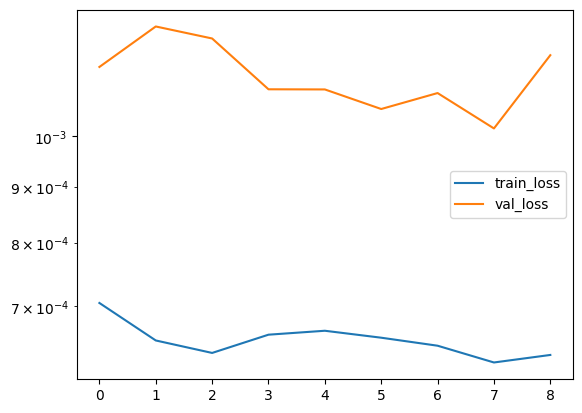

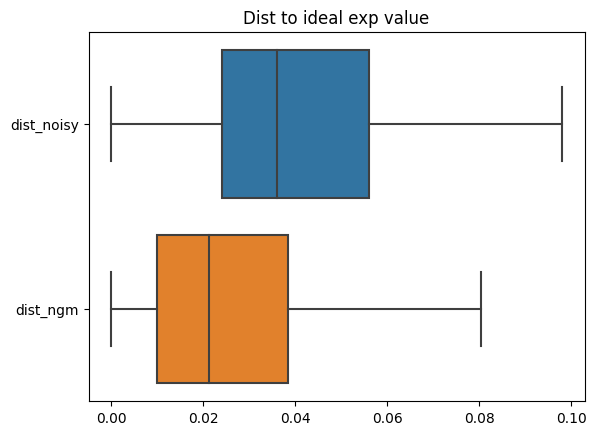

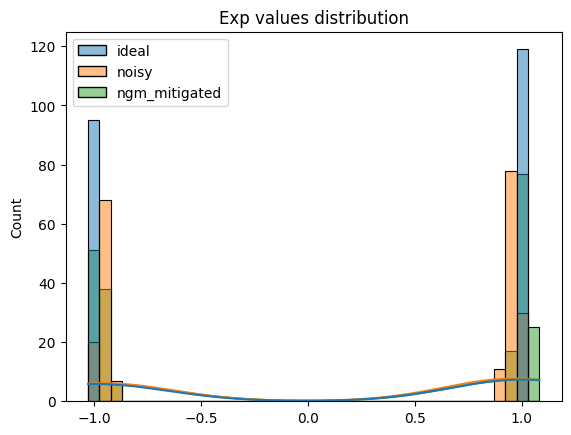

In [29]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
    
    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })
        
df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()